
# MRI Imaging and Segmentation of Brain
This tutorial considers the well-known problem of MRI imaging, where given the availability of a sparsely sampled
KK-spectrum, one is tasked to reconstruct the underline spatial luminosity of an object under observation. In
this specific case, we will be using an example from `Corona et al., 2019, Enhancing joint reconstruction and
segmentation with non-convex Bregman iteration`.

We first consider the imaging problem defined by the following cost functuon

\begin{align}\argmin_\mathbf{x} \|\mathbf{y}-\mathbf{Ax}\|_2^2 + \alpha TV(\mathbf{x})\end{align}

where the operator $\mathbf{A}$ performs a 2D-Fourier transform followed by sampling of the KK plane, $\mathbf{x}$
is the object of interest and $\mathbf{y}$ the set of available Fourier coefficients.

Once the model is reconstructed, we solve a second inverse problem with the aim of segmenting the retrieved object into
$N$ classes of different luminosity.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylops
from scipy.io import loadmat
from brainweb_dl import get_mri

import pyproximal

plt.close('all')
np.random.seed(10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/christophermarouani/opt/anaconda3/envs/msk_v/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mri_data = get_mri(sub_id=43, contrast="T1")
mri_data = mri_data[::-1, ...]
image = mri_data[90, :, :]


In [3]:
def power_density_mask(kspace_shape,m):
    power_mask = np.zeros(kspace_shape, dtype=float)
    center_x, center_y = power_mask.shape[0] // 2, power_mask.shape[1] // 2
    max_radius = np.sqrt(center_x ** 2 + center_y ** 2)

    for i in range(power_mask.shape[0]):
        for j in range(power_mask.shape[1]):
            radius = 1 + np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)/max_radius
            # give a 1 with probability

            power_mask[i, j] =  np.random.uniform(0, 1) < 2/(1+radius**m)

    return power_mask

shape = image.shape

mask = power_density_mask(shape, 8)

# print the sparsity of the mask
print("Sparsity: ", np.sum(mask) / mask.size)

Sparsity:  0.1114959716796875


Let's start by loading the data and the sampling mask



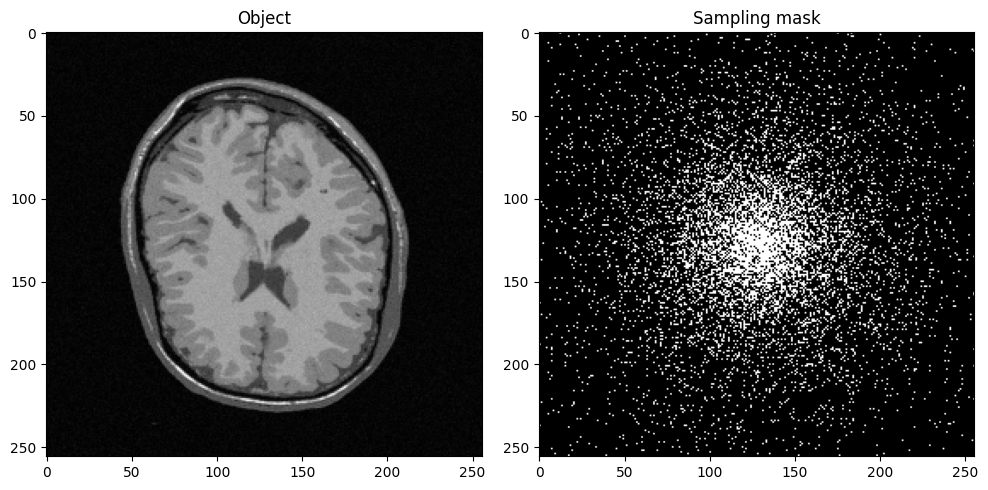

In [4]:
gt = image/256
sampling = mask
sampling1 = np.fft.fftshift(sampling)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(gt, cmap='gray')
axs[0].axis('tight')
axs[0].set_title("Object")
axs[1].imshow(sampling, cmap='gray')
axs[1].axis('tight')
axs[1].set_title("Sampling mask")
plt.tight_layout()

We can now create the MRI operator



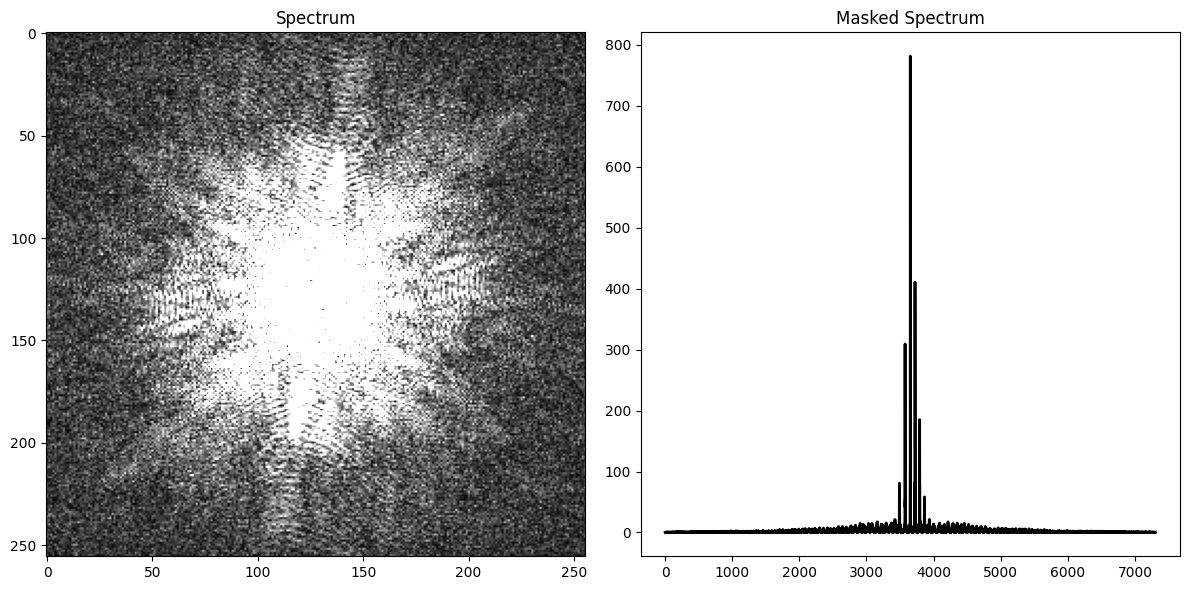

In [5]:
Fop = pylops.signalprocessing.FFT2D(dims=gt.shape)
Rop = pylops.Restriction(gt.size, np.where(sampling1.ravel() == 1)[0],
                         dtype=np.complex128)
Dop = Rop * Fop

# KK spectrum
GT = Fop * gt.ravel()
GT = GT.reshape(gt.shape)

# Data (Masked KK spectrum)
d = Dop * gt.ravel()

# add noise to d

d = d + np.random.normal(0, 0.01, d.shape) + 1j * np.random.normal(0, 0.01, d.shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(np.fft.fftshift(np.abs(GT)), vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title("Spectrum")
axs[1].plot(np.fft.fftshift(np.abs(d)),'k', lw=2)
axs[1].axis('tight')
axs[1].set_title("Masked Spectrum")
plt.tight_layout()

Let's try now to reconstruct the object from its measurement. The simplest
approach entails simply filling the missing values in the KK spectrum with
zeros and applying inverse FFT.



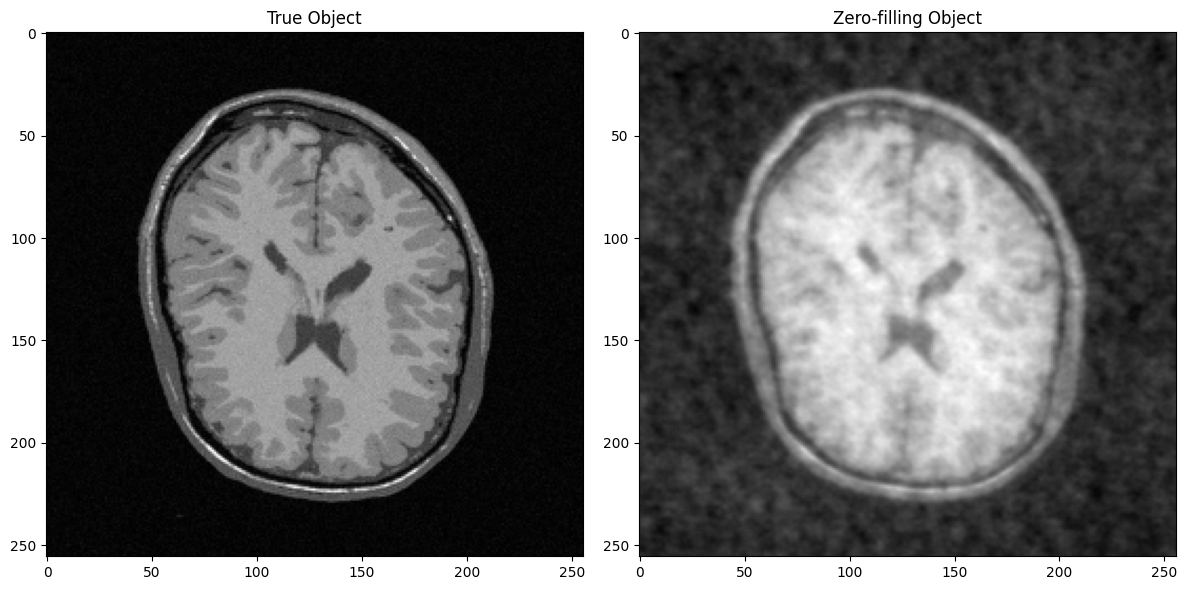

In [6]:
GTzero = sampling1 * GT
gtzero = (Fop.H * GTzero).real

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(gt, cmap='gray')
axs[0].axis('tight')
axs[0].set_title("True Object")
axs[1].imshow(gtzero, cmap='gray')
axs[1].axis('tight')
axs[1].set_title("Zero-filling Object")
plt.tight_layout()

(131072, 65536)
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.linearoperator._ScaledLinearOperator'>
Additional vector (z): None
tau = 8.750446417183525		mu = 8.750446417183525
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1  -2.29257e-02   7.324e+03   7.508e+02   0.000e+00       8.074e+03
     2  -2.42650e-02   8.585e+01   8.100e+02   0.000e+00       8.958e+02
     3  -3.60032e-02   1.248e+01   7.996e+02   0.000e+00       8.121e+02


/Users/christophermarouani/opt/anaconda3/envs/msk_v/lib/python3.12/site-packages/pyproximal/optimization/primaldual.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = '%6g  %12.5e  %10.3e  %10.3e  %10.3e      %10.3e' % \


     4  -7.46633e-02   1.743e+01   7.780e+02   0.000e+00       7.955e+02
     5  -1.40595e-01   2.322e+01   7.573e+02   0.000e+00       7.805e+02
     6  -2.17079e-01   2.817e+01   7.439e+02   0.000e+00       7.721e+02
     7  -2.99597e-01   3.198e+01   7.403e+02   0.000e+00       7.723e+02
     8  -3.80269e-01   3.465e+01   7.462e+02   0.000e+00       7.809e+02
     9  -4.50987e-01   3.640e+01   7.599e+02   0.000e+00       7.963e+02
    10  -4.95781e-01   3.748e+01   7.770e+02   0.000e+00       8.144e+02
    11  -5.26169e-01   3.811e+01   7.932e+02   0.000e+00       8.313e+02
    21   1.36023e-01   4.006e+01   8.550e+02   0.000e+00       8.951e+02
    31   5.87555e-01   4.140e+01   8.427e+02   0.000e+00       8.841e+02
    41   4.57595e-01   4.288e+01   8.201e+02   0.000e+00       8.629e+02
    51   3.24354e-01   4.396e+01   8.063e+02   0.000e+00       8.502e+02
    61   3.17918e-01   4.472e+01   7.958e+02   0.000e+00       8.405e+02
    71   4.03995e-01   4.557e+01   7.853e+02   0.00

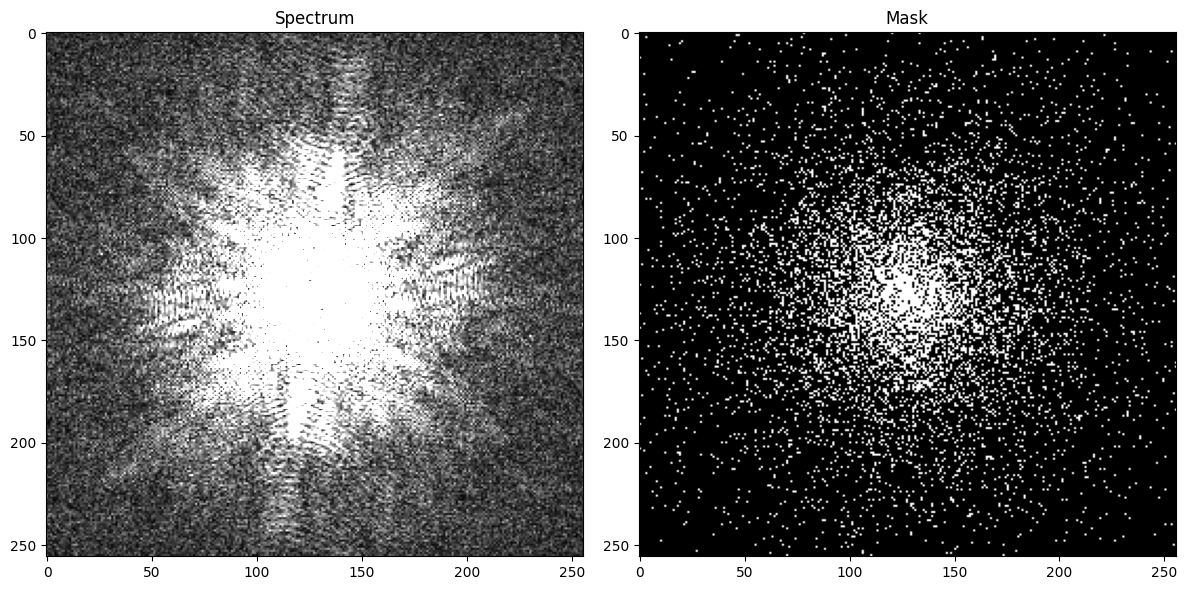

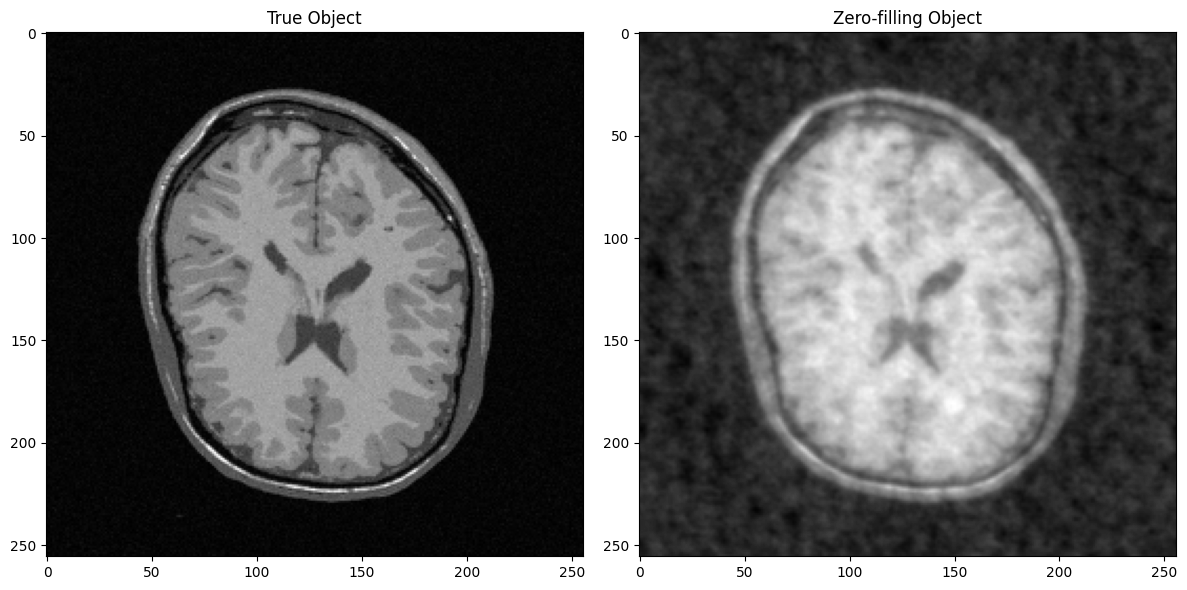

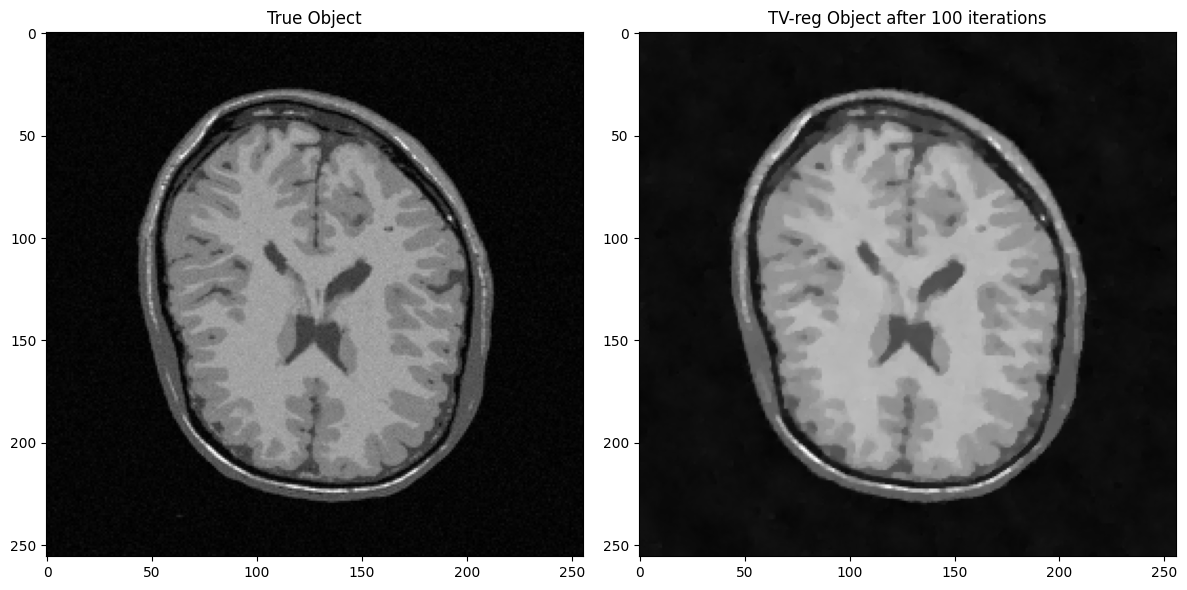

In [7]:

image = mri_data[90, :, :]
kspace = np.fft.fftshift(np.fft.fft2(image))
shape = kspace.shape
mask =  power_density_mask(shape, 8)

prior = pyproximal.proximal.L21(ndim=2)

def reconstruction(kspace, mask, prior=pyproximal.proximal.L21(ndim=2), prio_coeff=1, n_iter=100):

    image = np.fft.ifft(kspace)
    ground_truth = image/256
    sampling = mask
    sampling1 = np.fft.fftshift(sampling)


    Fop = pylops.signalprocessing.FFT2D(dims=gt.shape)
    Rop = pylops.Restriction(gt.size, np.where(sampling1.ravel() == 1)[0],
                            dtype=np.complex128)
    Dop = Rop * Fop

    # KK spectrum
    GT = Fop * gt.ravel()
    GT = GT.reshape(gt.shape)

    # Data (Masked KK spectrum)
    d = Dop * gt.ravel()

    # add noise to d

    d = d + np.random.normal(0, 0.01, d.shape) + 1j * np.random.normal(0, 0.01, d.shape)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(np.fft.fftshift(np.abs(GT)), vmin=0, vmax=1, cmap='gray')
    axs[0].axis('tight')
    axs[0].set_title("Spectrum")
    axs[1].imshow(mask, cmap='gray')
    axs[1].axis('tight')
    axs[1].set_title("Mask")
    plt.tight_layout()

    GTzero = sampling1 * GT
    gtzero = (Fop.H * GTzero).real

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(gt, cmap='gray')
    axs[0].axis('tight')
    axs[0].set_title("True Object")
    axs[1].imshow(gtzero, cmap='gray')
    axs[1].axis('tight')
    axs[1].set_title("Zero-filling Object")
    plt.tight_layout()

    with pylops.disabled_ndarray_multiplication():
        sigma = 0.04
        prior = pyproximal.proximal.L21(ndim=2)
        data_fidelity = pyproximal.proximal.L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
        Gop = sigma * pylops.Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex128)

        L = sigma ** 2 * 8
        tau = .99 / np.sqrt(L)
        mu = .99 / np.sqrt(L)

        print(Gop.shape)
        gtpd = pyproximal.optimization.primaldual.PrimalDual(data_fidelity, prior, Gop, x0=np.zeros(gt.size),
                                                            tau=tau, mu=mu, theta=1.,
                                                            niter=n_iter, show=True)
        gtpd = np.real(gtpd.reshape(gt.shape))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(gt, cmap='gray')
    axs[0].axis('tight')
    axs[0].set_title("True Object")
    axs[1].imshow(gtpd, cmap='gray')
    axs[1].axis('tight')
    axs[1].set_title("TV-reg Object after %d iterations" % n_iter)
    plt.tight_layout()

reconstruction(kspace, mask, prior)

We can now do better if we introduce some prior information in the form of
TV on the solution



(131072, 65536)
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.linearoperator._ScaledLinearOperator'>
Additional vector (z): None
tau = 8.750446417183525		mu = 8.750446417183525
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1  -1.21602e-01   7.346e+03   7.414e+02   0.000e+00       8.088e+03
     2  -1.75573e-01   8.587e+01   7.998e+02   0.000e+00       8.857e+02


/Users/christophermarouani/opt/anaconda3/envs/msk_v/lib/python3.12/site-packages/pyproximal/optimization/primaldual.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = '%6g  %12.5e  %10.3e  %10.3e  %10.3e      %10.3e' % \


     3  -2.27826e-01   1.210e+01   7.895e+02   0.000e+00       8.016e+02
     4  -2.73626e-01   1.687e+01   7.684e+02   0.000e+00       7.852e+02
     5  -3.03712e-01   2.256e+01   7.480e+02   0.000e+00       7.706e+02
     6  -3.09058e-01   2.754e+01   7.348e+02   0.000e+00       7.623e+02
     7  -2.91037e-01   3.140e+01   7.307e+02   0.000e+00       7.621e+02
     8  -2.62716e-01   3.419e+01   7.365e+02   0.000e+00       7.707e+02
     9  -2.26210e-01   3.606e+01   7.494e+02   0.000e+00       7.854e+02
    10  -1.64365e-01   3.730e+01   7.648e+02   0.000e+00       8.021e+02
    11  -1.00343e-01   3.813e+01   7.799e+02   0.000e+00       8.180e+02
    21   4.59181e-01   4.059e+01   8.461e+02   0.000e+00       8.867e+02
    31   7.89452e-01   4.123e+01   8.432e+02   0.000e+00       8.844e+02
    41   6.74475e-01   4.247e+01   8.158e+02   0.000e+00       8.583e+02
    51   3.84448e-01   4.404e+01   7.974e+02   0.000e+00       8.414e+02
    61   1.27746e-01   4.520e+01   7.881e+02   0.00

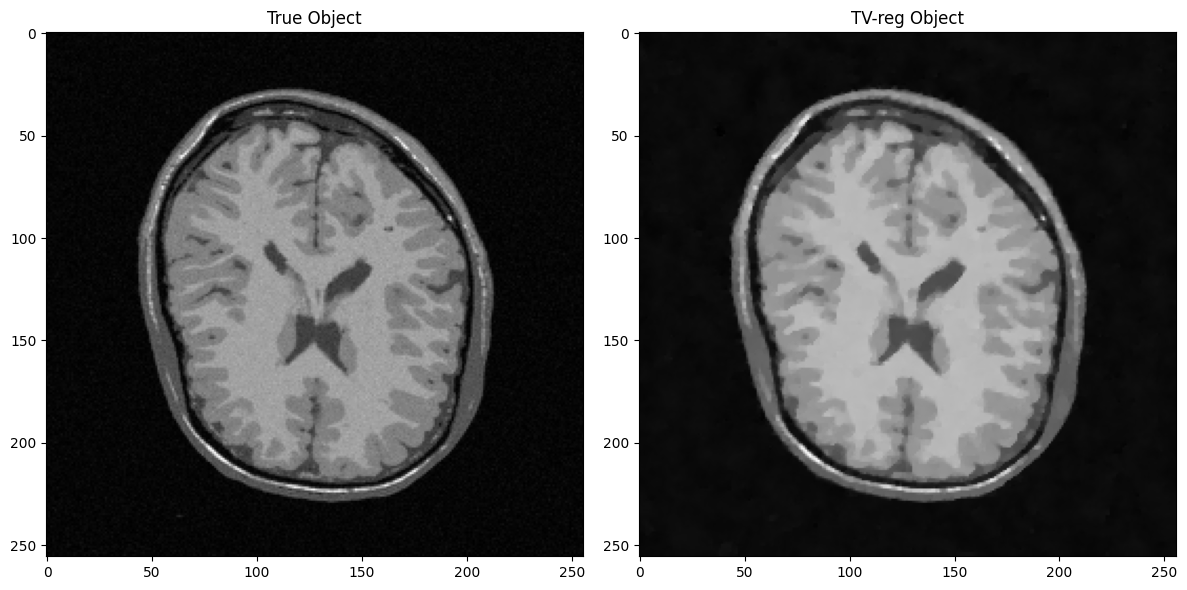

In [286]:


with pylops.disabled_ndarray_multiplication():
    sigma = 0.04
    l1 = pyproximal.proximal.L21(ndim=2)
    l2 = pyproximal.proximal.L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
    Gop = sigma * pylops.Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex128)

    L = sigma ** 2 * 8
    tau = .99 / np.sqrt(L)
    mu = .99 / np.sqrt(L)

    print(Gop.shape)
    gtpd = pyproximal.optimization.primaldual.PrimalDual(l2, l1, Gop, x0=np.zeros(gt.size),
                                                         tau=tau, mu=mu, theta=1.,
                                                         niter=100, show=True)
    gtpd = np.real(gtpd.reshape(gt.shape))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(gt, cmap='gray')
axs[0].axis('tight')
axs[0].set_title("True Object")
axs[1].imshow(gtpd, cmap='gray')
axs[1].axis('tight')
axs[1].set_title("TV-reg Object")
plt.tight_layout()